In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__

Applied a high frequency filter, removing all components smaller than 0.03 um


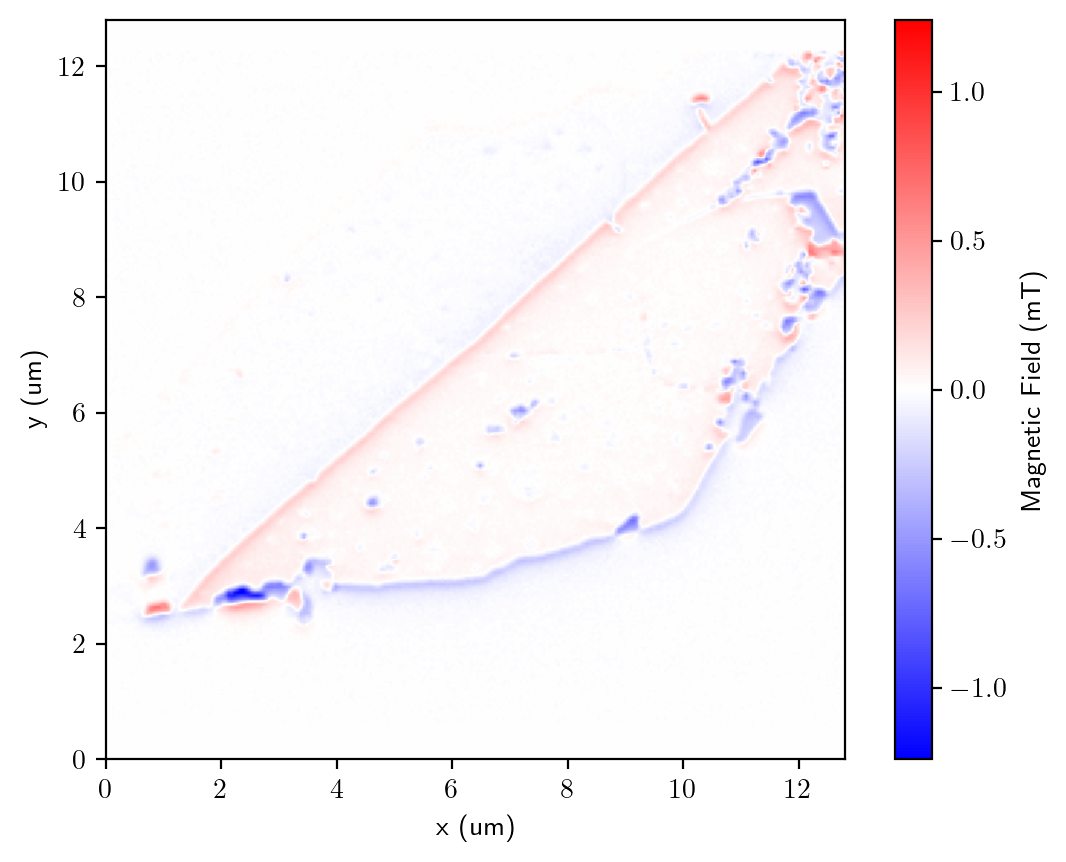

In [60]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6 # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 92
height = 30e-3 # um
layer_thickness = 0

dataset = Data()
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, layer_thickness)

# Add filter 
dataset.add_hanning_filter(height)
dataset.add_short_wavelength_filter(height)

dataset.remove_DC_background()
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()



In [61]:
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.03
2,short_wavelength_filter,False,None,"Applied a high frequency filter, removing all ...",wavelength = 0.03
3,remove_DC_background,False,None,Removed the DC background from the data,None
4,crop_data,False,crop_data,crop the data with the given region of interest,"roi = [0,256,0,256,]"
5,pad_data,True,crop_data,Padded the data to a square image with dimensi...,None


# Transfor Bsensor into Bxyz

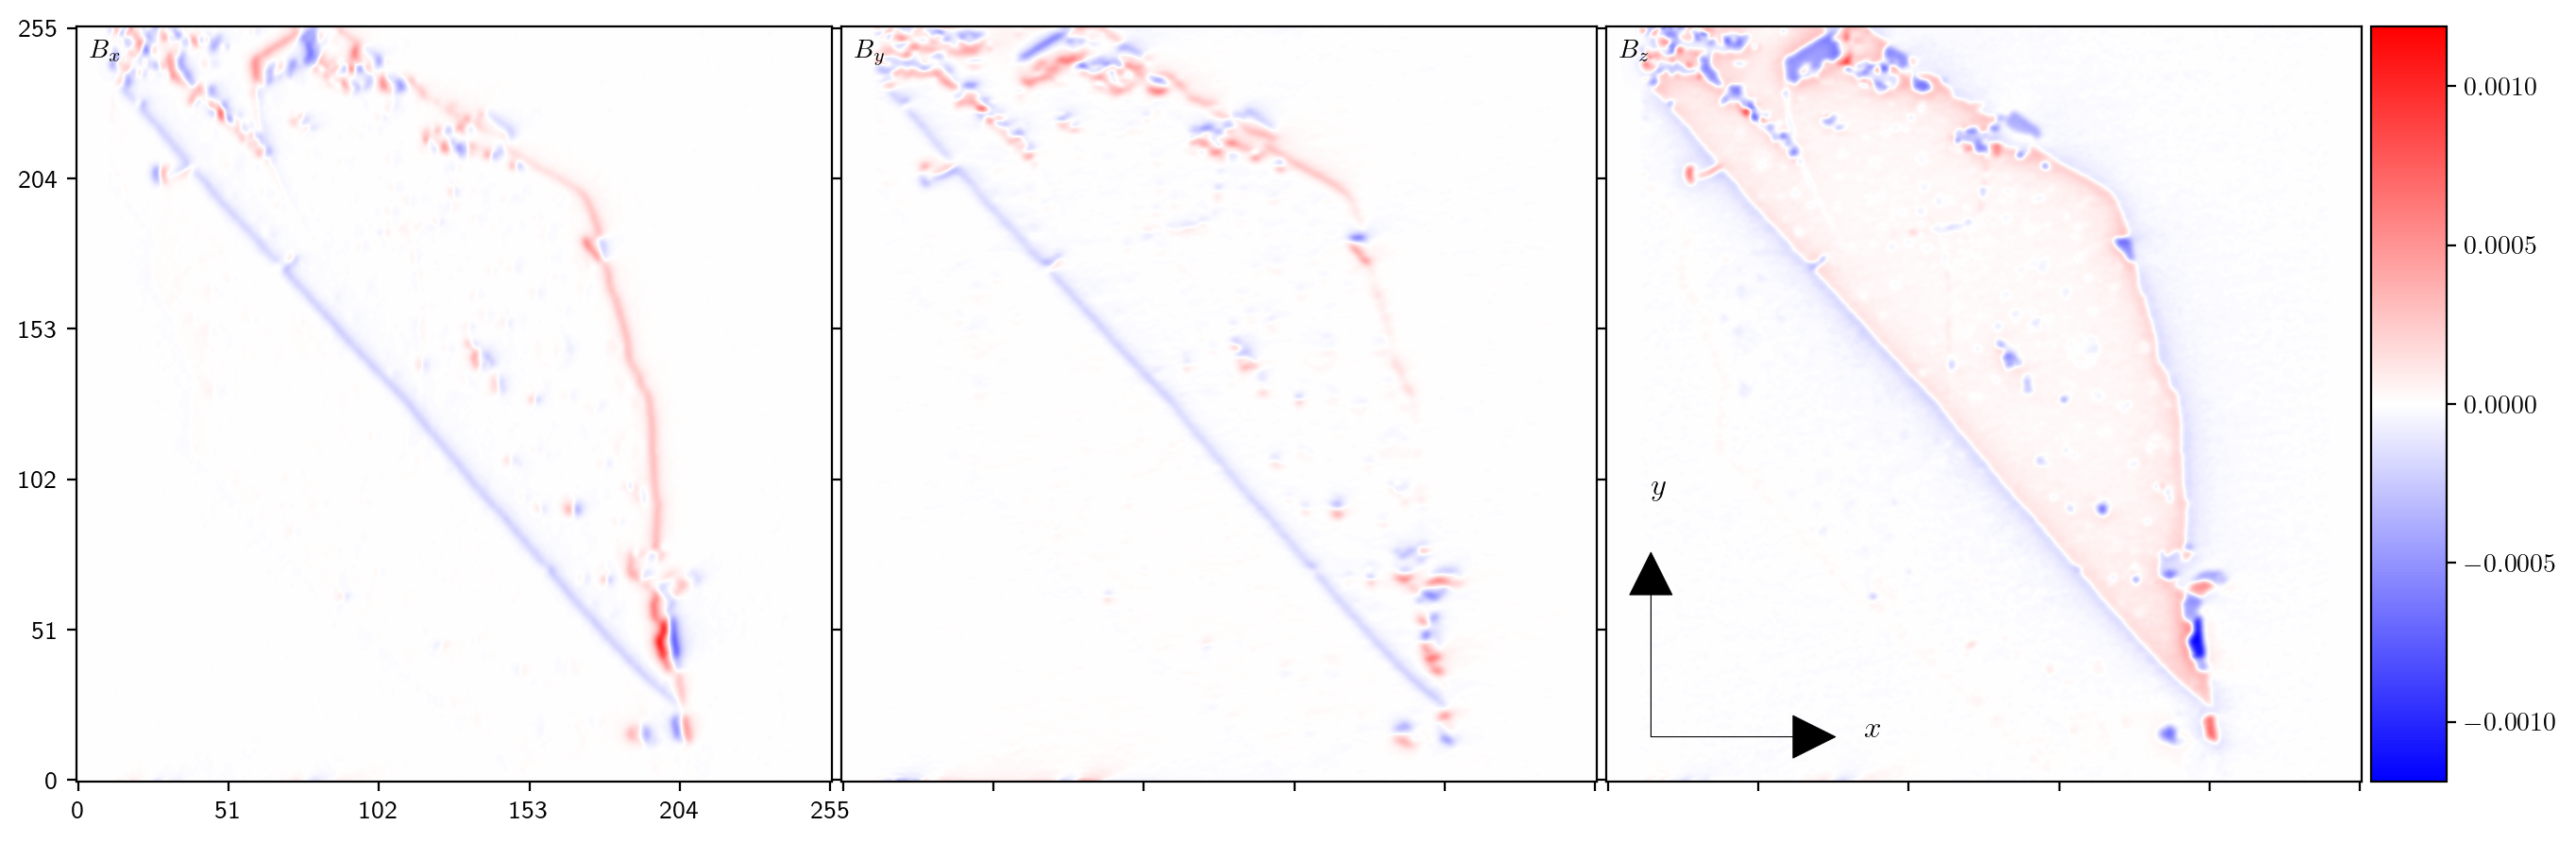

In [62]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Reconstruct the out of plane magnetisation using the B sensor

Applied a high frequency filter, removing all components smaller than 0.03 um
no input provided, using the dataset target


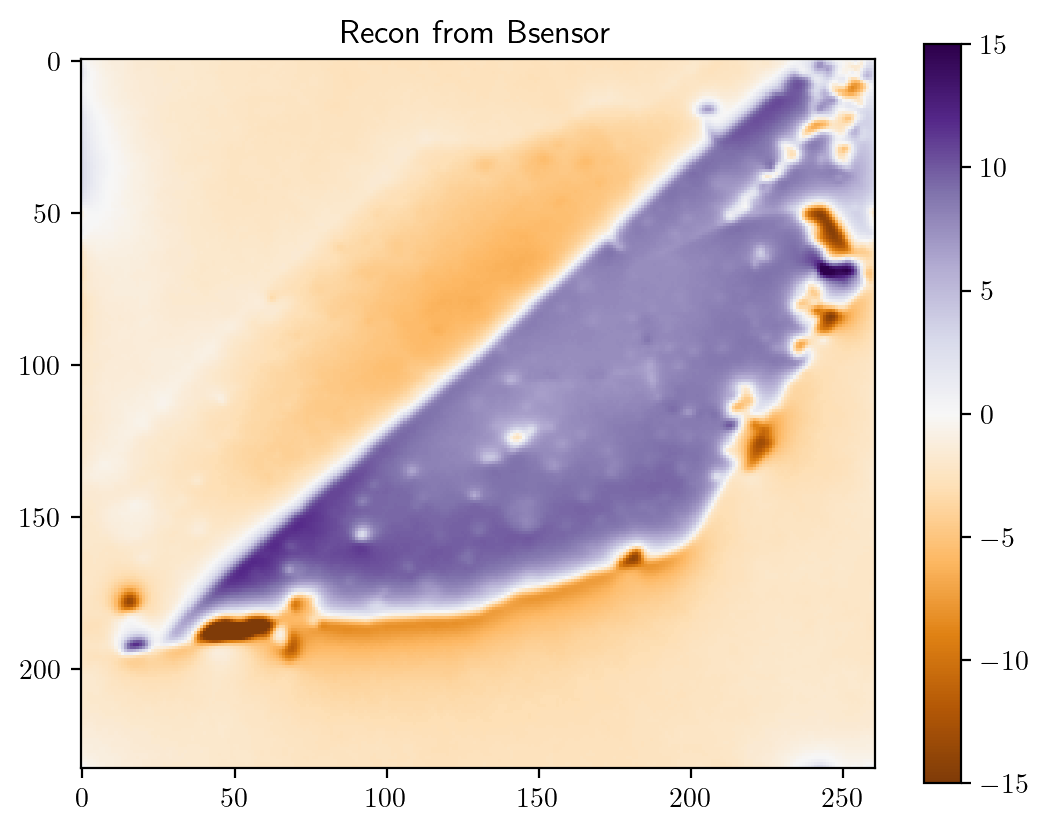

In [71]:

dataset2 = Data()
dataset2.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, layer_thickness)
dataset2.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi =0)

dataset2.transform_data()

plt.figure()
plt.imshow(-1*dataset2.transformed_target, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from Bsensor")
plt.colorbar()


## Reconstruct using only the Bz magnetic field component

Applied a high frequency filter, removing all components smaller than 0.03 um
no input provided, using the dataset target


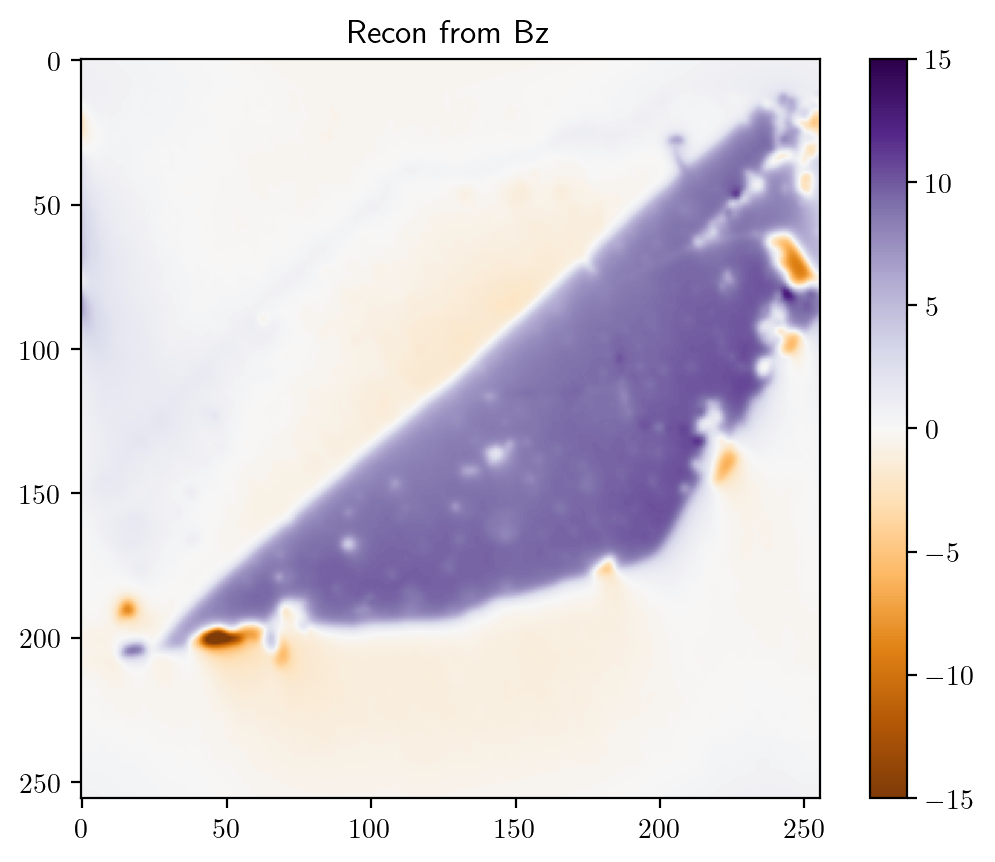

In [70]:
dataset3 = copy.deepcopy(dataset)
dataset3.target = dataset.transformed_target[2,::]
dataset3.define_sensor_angles(0, 0)
dataset3.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi = 0)
dataset3.transform_data()

plt.figure()
plt.imshow(-1*dataset3.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from Bz")
plt.colorbar()


# Check that the transformation works in the inverse direction

<Figure size 640x480 with 0 Axes>

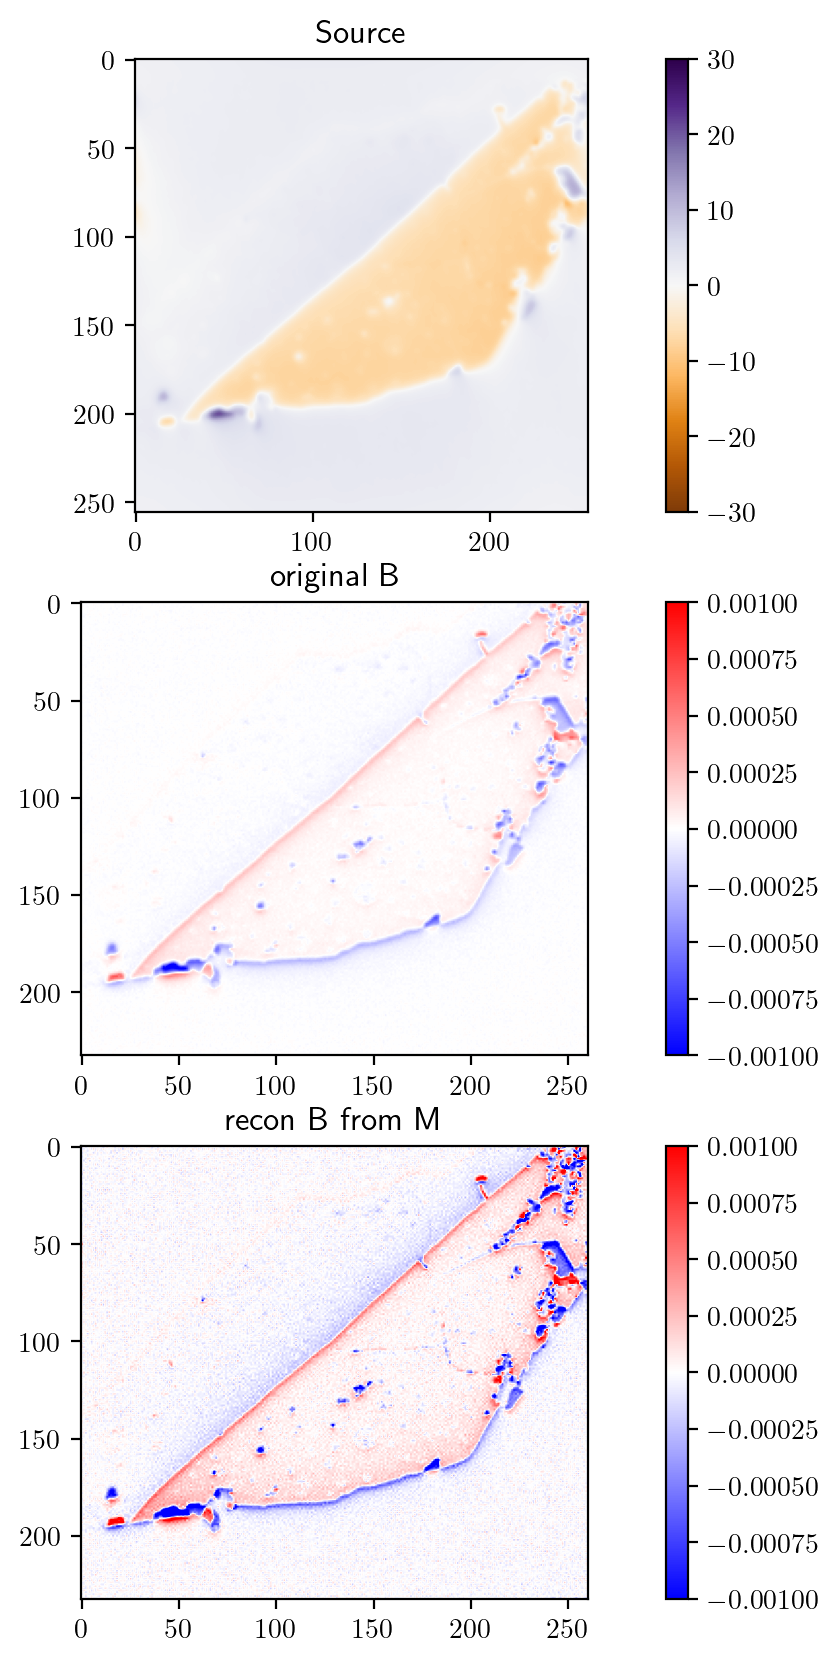

In [75]:
from magrec.transformation.Mxy2Bsensor import Mxy2Bsensor

dataset3.target = dataset2.transformed_target
dataset3.define_sensor_angles(0, 0)
dataset3.define_height(0.05)

magClass = Mxy2Bsensor(dataset3, m_theta = 0, m_phi = 0)

btest = magClass.transform(dataset3.target)

plt.figure()
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.imshow(dataset3.transformed_target, cmap="PuOr", vmin=-30, vmax=30)
plt.title("Source")
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(dataset2.target, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.title("original B")
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(btest, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.title("recon B from M")
plt.colorbar()

## Now we will try to reconstruct the magnetisation using a neural network.

To begin with let's just test that we can acutally transform a magnetisation to a B-field correctly

In [105]:
from magrec.method.CNN import CNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

NN_recon_data = Data()
sensor_theta = 0 
sensor_phi = 0 
NN_recon_data.load_data(dataset.transformed_target[2,::], dx, dy, height, sensor_theta, sensor_phi, layer_thickness)

# Define the model of the source that will be reconstructed
Model = UniformMagnetisation(NN_recon_data, 
                             loss_type = "MSE", 
                             m_theta = 0, 
                             m_phi = 0,
                             scaling_factor = 1e6,
                             source_weight = None,
                             loss_weight = None, )

# Define the fitting method and pass it the model
FittingMethod = CNN(Model, learning_rate = 0.1)



Number of sources: 1
Number of targets: 1


epoch     1 | loss on last mini-batch:  9.64e+02
epoch    11 | loss on last mini-batch:  7.33e+02
epoch    21 | loss on last mini-batch:  6.04e+02
epoch    31 | loss on last mini-batch:  5.29e+02
epoch    41 | loss on last mini-batch:  4.84e+02
epoch    51 | loss on last mini-batch:  4.48e+02
epoch    61 | loss on last mini-batch:  3.94e+02
epoch    71 | loss on last mini-batch:  3.68e+02
epoch    81 | loss on last mini-batch:  3.32e+02
epoch    91 | loss on last mini-batch:  3.03e+02
epoch   101 | loss on last mini-batch:  2.92e+02
epoch   111 | loss on last mini-batch:  2.59e+02
epoch   121 | loss on last mini-batch:  2.57e+02
epoch   131 | loss on last mini-batch:  2.40e+02
epoch   141 | loss on last mini-batch:  2.19e+02
epoch   151 | loss on last mini-batch:  2.06e+02
epoch   161 | loss on last mini-batch:  2.08e+02
epoch   171 | loss on last mini-batch:  1.93e+02
epoch   181 | loss on last mini-batch:  1.85e+02
epoch   191 | loss on last mini-batch:  1.77e+02


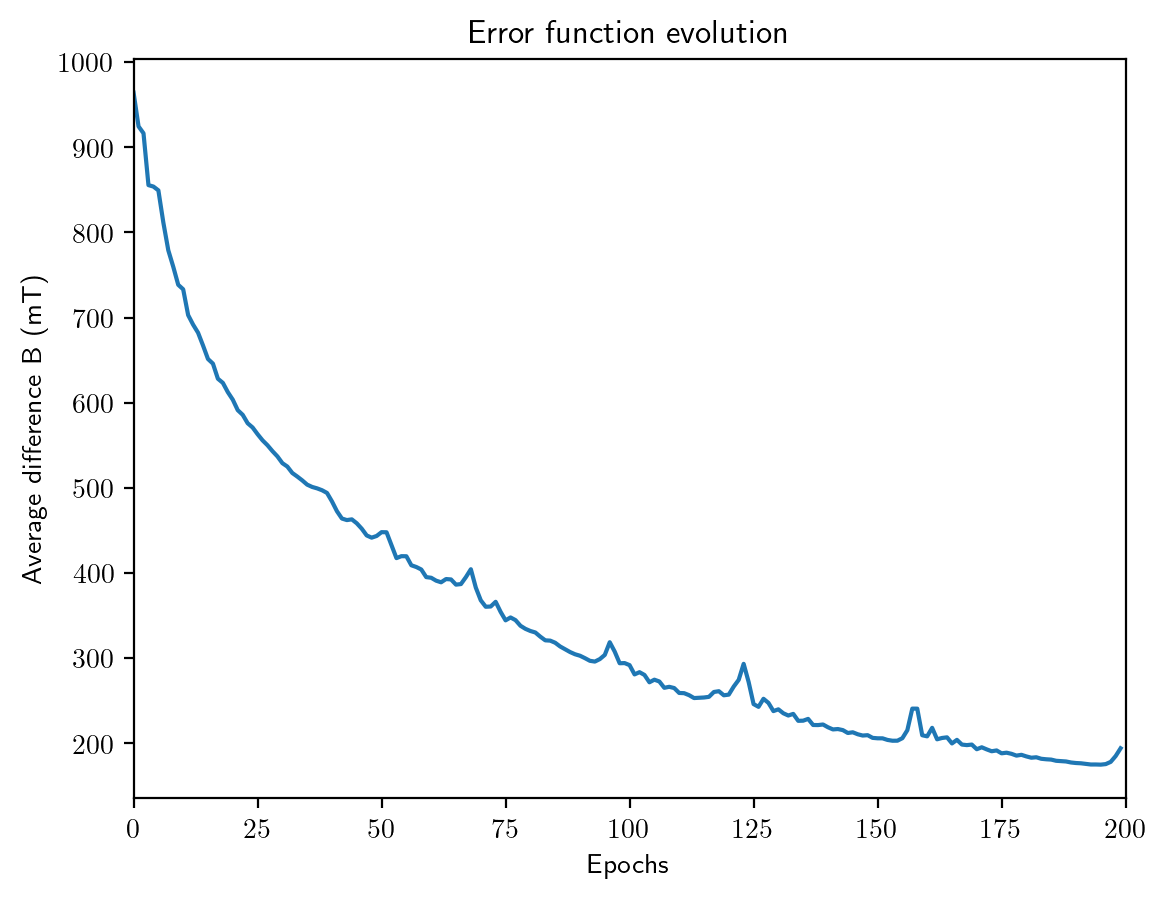

In [109]:
FittingMethod.fit(n_epochs=200)
FittingMethod.plot_loss()

Removed the padding that was applied to the data


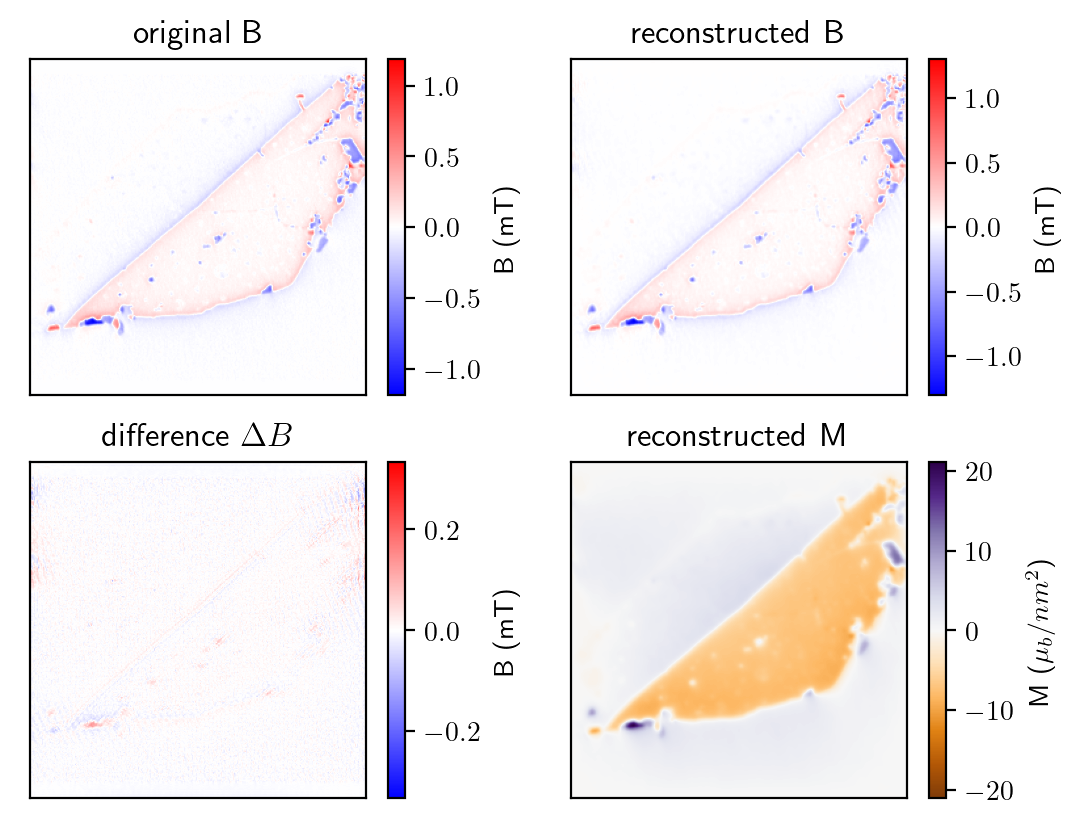

In [110]:
FittingMethod.extract_results()
FittingMethod.plot_results()

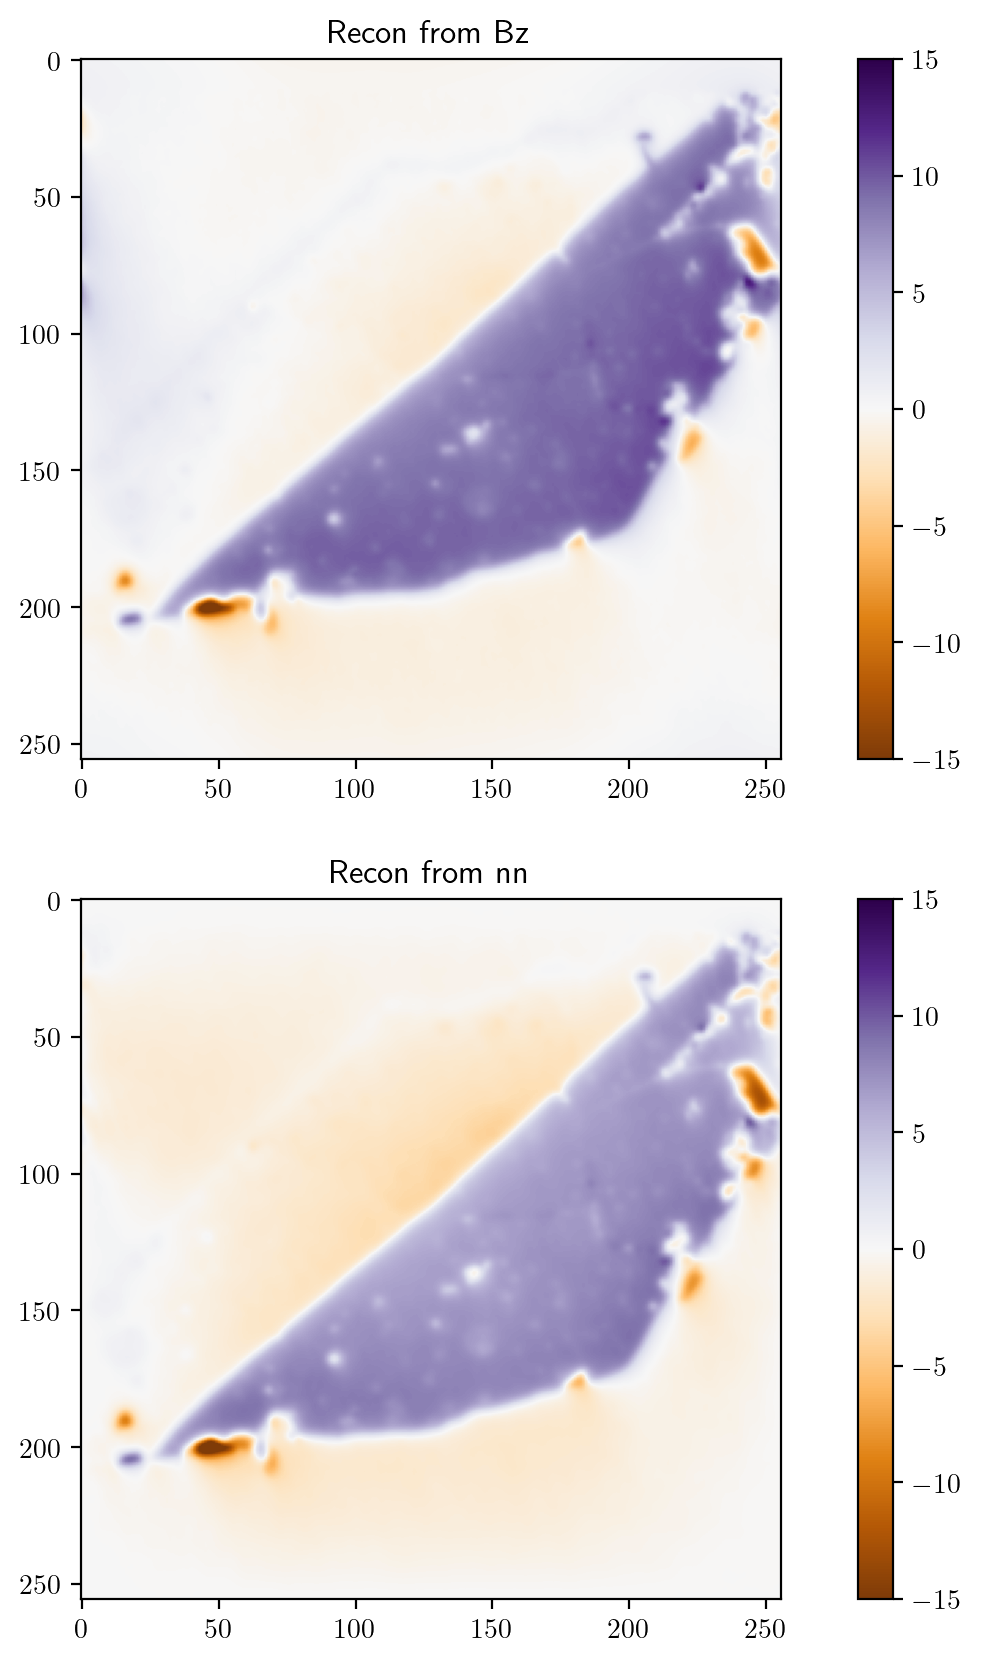

In [111]:
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.imshow(-1*dataset3.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from Bz")
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(-1*FittingMethod.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from nn")
plt.colorbar()
